In [2]:
import sys
import os
sys.path.insert(0, os.path.join('..', '..'))
import importlib
import random
import time

import sklearn
import numpy as np
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import pandas as pd

import Data
import SigMahaKNN
import UCR_data_support

In [3]:
DATA_DIR = '/Users/zoos/PycharmProjects/Anomaly_detection/data/'
importlib.reload(Data)
importlib.reload(SigMahaKNN)

<module 'SigMahaKNN' from '/Users/zoos/PycharmProjects/Anomaly_detection/SigMahaKNN.py'>

### Pen digit data example; Reproduce the result.

In [30]:
data = Data.Data(n_samples=(800, 30, 30), if_sample=False)
data.load_pen_digit()

In [31]:
%%time
depth_to_auc = {}
for depth in [1,2,3,4,5]:
    digit_to_inlier_dists = {}
    digit_to_outlier_dists = {}

    for digit in range(10):
        data.load_pen_digit(digit=digit)
        print("doing digit", digit, "doing signature level ", depth)
        signature_maha_knn = SigMahaKNN.SignatureMahalanobisKNN(
            augmentation_list=None,
            depth=depth,
        )
        # Measure the time spent on fit
        start_time = time.time()
        signature_maha_knn.fit(data.corpus)
        fit_time = time.time() - start_time
        print("fit_time: ", fit_time)
        
        # Measure the time spent on conformance
        start_time = time.time()
        inlier_dists = signature_maha_knn.conformance(data.test_inlier)
        outlier_dists = signature_maha_knn.conformance(data.test_outlier)
        compute_auc_time = time.time() - start_time
        print("compute_auc_time: ", compute_auc_time)  

        digit_to_inlier_dists[digit] = inlier_dists
        digit_to_outlier_dists[digit] = outlier_dists

        auc = signature_maha_knn.compute_auc_given_dists(inlier_dists, outlier_dists)
        print("depth: ", depth, ", Auc of", " digit: ", digit, " is ", auc)

    all_inlier_dists = np.concatenate(list(digit_to_inlier_dists.values()))
    all_outlier_dists = np.concatenate(list(digit_to_outlier_dists.values()))
    auc = signature_maha_knn.compute_auc_given_dists(all_inlier_dists, all_outlier_dists)
    print("Overall, ", "depth: ", depth, "AUC: ", auc)
    depth_to_auc[depth] = auc


doing digit 0 doing signature level  1
fit_time:  0.3027667999267578
compute_auc_time:  12.577699899673462
depth:  1 , Auc of  digit:  0  is  0.9227665959288405
doing digit 1 doing signature level  1
fit_time:  0.33161425590515137


KeyboardInterrupt: 

In [9]:
print(depth_to_auc)

{1: 0.9005625529380343, 2: 0.964238270380864, 3: 0.9830996477462921, 4: 0.987341800658305, 5: 0.988725068158599}


### Ship movement data example

In [32]:
data = Data.Data(
    n_samples=(800, 30, 30),
    if_sample=True,
)

In [33]:
%%time
lead_lag_and_inv_rest_and_thres_distance_to_auc = {}
for lead_lag in [True, False]:
    augmentation_list1 = []
    lead_lag_and_inv_rest_and_thres_distance_to_auc[lead_lag] = {}
    if lead_lag:
        augmentation_list1.append('leadlag')
    for inv_reset in [True, False]:
        lead_lag_and_inv_rest_and_thres_distance_to_auc[lead_lag][inv_reset] = {}
        if inv_reset:
            augmentation_list = augmentation_list1 + ['ir']
        else:
            augmentation_list = augmentation_list1

        if (not inv_reset) and (not lead_lag):
            augmentation_list = None
            
        for thres_distance in [4000, 8000, 16000, 32000]:
            signature_maha_knn = SigMahaKNN.SignatureMahalanobisKNN(
                augmentation_list=augmentation_list,
                depth=3,
            )
            data.load_ship_movements(
                thres_distance=thres_distance,
            )
            # Measure the time spent on fit
            start_time = time.time()
            signature_maha_knn.fit(data.corpus)
            fit_time = time.time() - start_time
            print("fit_time: ", fit_time)

            
            # Measure the time spent on compute_auc
            start_time = time.time()
            auc = signature_maha_knn.compute_auc(data.test_inlier, data.test_outlier)
            compute_auc_time = time.time() - start_time
            print("compute_auc_time: ", compute_auc_time)

            
            print("lead_lag: ", lead_lag, "inv_rest: ", 
                  inv_reset, "thres_distance: ", thres_distance, "auc: ", auc)
            lead_lag_and_inv_rest_and_thres_distance_to_auc[lead_lag][inv_reset][thres_distance] = auc


fit_time:  5.109290838241577
compute_auc_time:  6976.520172119141
lead_lag:  True inv_rest:  True thres_distance:  4000 auc:  0.82775484
fit_time:  6.680724382400513
compute_auc_time:  5328.486763000488
lead_lag:  True inv_rest:  True thres_distance:  8000 auc:  0.82714924
fit_time:  5.782520055770874
compute_auc_time:  5452.072140216827
lead_lag:  True inv_rest:  True thres_distance:  16000 auc:  0.83445568
fit_time:  5.54255485534668
compute_auc_time:  6833.051792860031
lead_lag:  True inv_rest:  True thres_distance:  32000 auc:  0.8481151199999999
fit_time:  4.539357900619507
compute_auc_time:  5871.910370111465
lead_lag:  True inv_rest:  False thres_distance:  4000 auc:  0.8309026800000001
fit_time:  4.627004146575928
compute_auc_time:  6522.567795991898
lead_lag:  True inv_rest:  False thres_distance:  8000 auc:  0.82968328
fit_time:  4.993413209915161
compute_auc_time:  5267.206535100937
lead_lag:  True inv_rest:  False thres_distance:  16000 auc:  0.8379764399999999
fit_time:  4

KeyboardInterrupt: 

### UCR data example

In [4]:
%%time
data = Data.Data(if_sample=True, n_samples=[100, 10, 10])
data_full_names = ['Adiac', 'ArrowHead', 'Beef', 'BeetleFly', 'BirdChicken', 'CBF',
       'ChlorineConcentration', 'Coffee', 'ECG200', 'ECGFiveDays', 'FaceFour',
       'GunPoint', 'Ham', 'Herring', 'Lightning2', 'Lightning7', 'Meat',
       'MedicalImages', 'MoteStrain', 'Plane', 'Strawberry', 'Symbols',
       'ToeSegmentation1', 'ToeSegmentation2', 'Trace', 'TwoLeadECG', 'Wafer',
       'Wine']
signature_maha_knn = SigMahaKNN.SignatureMahalanobisKNN(
    augmentation_list=("addtime",),
    depth=5,
)
anomaly_level = 0.001
iter = 10
data_names = data_full_names

roughpathsbest, roughpathserror = UCR_data_support.compute_best_and_std(data_names, iter, data, signature_maha_knn, anomaly_level)

anomaly_level = 0.05
roughpathsbest, roughpathserror = UCR_data_support.compute_best_and_std(data_names, iter, data, signature_maha_knn, anomaly_level)

CPU times: user 14min 33s, sys: 29min 17s, total: 43min 51s
Wall time: 5min 56s


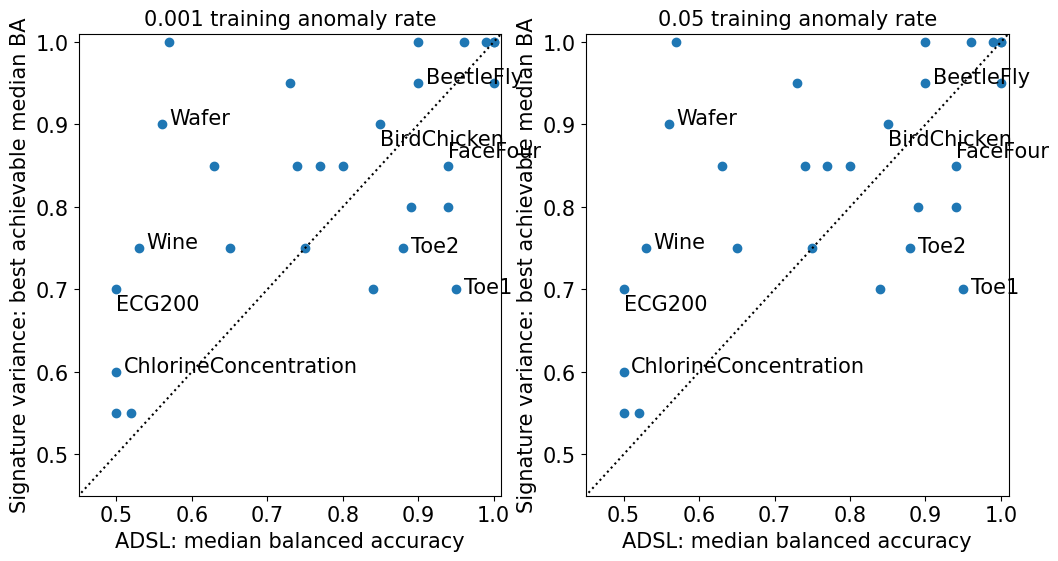

In [9]:
fig, axs = plt.subplots(1,2, figsize=(12, 6))
comparison_table_1 = UCR_data_support.plot_ucr_result(roughpathsbest, roughpathserror, anomaly_level=0.001, ax_num=0, axs=axs)
comparison_table_2 = UCR_data_support.plot_ucr_result(roughpathsbest, roughpathserror, anomaly_level=0.05, ax_num=1, axs=axs)
fig.savefig("benchmark.pdf")
plt.show()

In [6]:
comparison_table_1

,0,1,2,3,4
0,Adiac,1.0,0.0,0.99,0.1
1,ArrowHead,0.75,0.149443,0.65,0.03
2,Beef,1.0,0.0,0.57,0.15
3,BeetleFly,0.95,0.168655,0.9,0.08
4,BirdChicken,0.9,0.042164,0.85,0.15
5,CBF,0.85,0.073786,0.8,0.04
6,ChlorineConcentration,0.6,0.113529,0.5,0.0
7,Coffee,0.7,0.107497,0.84,0.04
8,ECG200,0.7,0.097183,0.5,0.03
9,ECGFiveDays,0.8,0.107497,0.94,0.11


In [7]:
comparison_table_2

,0,1,2,3,4
0,Adiac,1.0,0.0,0.99,0.1
1,ArrowHead,0.75,0.149443,0.65,0.03
2,Beef,1.0,0.0,0.57,0.15
3,BeetleFly,0.95,0.168655,0.9,0.08
4,BirdChicken,0.9,0.042164,0.85,0.15
5,CBF,0.85,0.073786,0.8,0.04
6,ChlorineConcentration,0.6,0.113529,0.5,0.0
7,Coffee,0.7,0.107497,0.84,0.04
8,ECG200,0.7,0.097183,0.5,0.03
9,ECGFiveDays,0.8,0.107497,0.94,0.11


### Language dataset example

In [ ]:
data.load_language_data()

In [ ]:
random.seed(1)
data.corpus = random.sample(list(data.corpus), 800)
data.test_inlier = random.sample(list(data.test_inlier), 10)
data.test_outlier = random.sample(list(data.test_outlier), 10)

##### Takes a while as signature dimension very large

In [ ]:
%%time
signature_maha_knn = SigMahaKNN.SignatureMahalanobisKNN()
signature_maha_knn.fit(data.corpus)
signature_maha_knn.compute_auc(data.test_inlier, data.test_outlier)